# Calibração de câmera com OpenCV

**Visão Computacional e Percepção - TA2**

**Henrique Luiz Rieger - GRR20190357**

O notebook original e o código-fonte deste relatório encontram-se [nesse repositório](https://github.com/henrieger/ta2-visao).

Este trabalho aplica as funções de calibração de câmeras da biblioteca OpenCV para reduzir distorções em imagens. O código foi majoritariamente obtido do [tutorial](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html) da própria biblioteca, com algumas alterações e utilizando fotografias próprias. A câmera calibrada foi uma webcam Logitech C925E Pro.

Primeiramente, foram obtidas 10 imagens de um tabuleiro de xadrex preto e branco 8x8. O tabuleiro estava fixado em uma superfície levemente flexível, o que introduziu mais alguns erros na calibração. Abaixo, está o código, conforme disponibilizado pela OpenCV, para obter os pontos em um espaço tridimensional e a projeção bidimensional dos mesmos no sensor da câmera.

In [1]:
import numpy as np
import cv2 as cv
import glob

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,6,0)
objp = np.zeros((7*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:7].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob('img/*.jpg')

for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (7,7), None)
    
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        
        # Draw and display the corners
        cv.drawChessboardCorners(img, (7,7), corners2, ret)
        cv.imshow('img', img)
        cv.waitKey(500)
        
cv.destroyAllWindows()

Após essa etapa, as características intrínsecas são obtidas com a chamada da função `cv.calibrateCamera`. O resultado apresentado é a matriz de características da câmera,

In [2]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print(mtx)

[[879.64824438   0.         475.08574496]
 [  0.         879.5161199  377.65027102]
 [  0.           0.           1.        ]]


onde os valores em ([0, 0], [1, 1]) correspondem à *distância focal da câmera*, enquanto os valores em ([0, 2], [1, 2]) formam o *centro óptico*.

Após essa etapa, são definidas duas funções, que correspondem a dois diferentes métodos para fazer as correções na distorção gerada pela câmera. A primeira, chamada `undistort`, utiliza o método nativo da OpenCV `cv.undistort` para gerar uma imagem corretamenta alinhada. Já a função `remap` utiliza os métodos `cv.initUndistortRectifyMap` e `cv.remap` para encontrar uma função que remapeie a imagem distorcida para uma sem distorções. Ambos os métodos devem gerar o mesmo resultado. Abaixo estão as implementações de ambas as funções. 

In [3]:
# undistort
def undistort(img):
    h,  w = img.shape[:2]
    newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
    
    dst = cv.undistort(img, mtx, dist, None, newcameramtx)
    
    # crop the image
    x, y, w, h = roi
    dst = dst[y:y+h, x:x+w]
    return dst

In [4]:
# remapping
def remap(img):
    h,  w = img.shape[:2]
    newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
    
    mapx, mapy = cv.initUndistortRectifyMap(mtx, dist, None, newcameramtx, (w,h), 5)
    dst = cv.remap(img, mapx, mapy, cv.INTER_LINEAR)
    
    # crop the image
    x, y, w, h = roi
    dst = dst[y:y+h, x:x+w]
    return dst

Vamos então conferir os resultados. Podemos usar uma janela interativa para escolher qualquer uma das 10 imagens iniciais e verificar o resultado da remoção de distorções. São gerados também sobreposições (*overlays*) de cada um dos métodos, a fim de comparar tanto o resultado em relação à imagem original quanto a diferença na aplicação de ambos.

In [5]:
import matplotlib.pyplot as plt
from ipywidgets import interactive

def results(path: str):
    img = cv.imread(path, cv.IMREAD_GRAYSCALE)
    
    # crop the image
    # generates a comparable image with both methods
    h,  w = img.shape[:2]
    newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
    x, y, w, h = roi
    new_img = img[y:y+h, x:x+w]

    plt.figure(figsize=(16,8))

    plt.subplot(231)
    plt.title('Imagem Original')
    plt.xticks([]), plt.yticks([])
    plt.imshow(new_img, 'gray')
    
    und = undistort(img)
    plt.subplot(232)
    plt.title('Undistort')
    plt.xticks([]), plt.yticks([])
    plt.imshow(und, 'gray')

    remp = remap(img)
    plt.subplot(233)
    plt.title('Remapping')
    plt.xticks([]), plt.yticks([])
    plt.imshow(remp, 'gray')

    plt.subplot(234)
    plt.title('Overlay Original + Undistort')
    plt.xticks([]), plt.yticks([])
    plt.imshow(und, 'gray')
    plt.imshow(new_img, 'gray', alpha=0.5)

    plt.subplot(235)
    plt.title('Overlay Original + Remap')
    plt.xticks([]), plt.yticks([])
    plt.imshow(remp, 'gray')
    plt.imshow(new_img, 'gray', alpha=0.5)

    plt.subplot(236)
    plt.title('Overlay Undistort + Remap')
    plt.xticks([]), plt.yticks([])
    plt.imshow(und, 'gray')
    plt.imshow(remp, 'gray', alpha=0.5)

images.sort()
interactive(results, path=images)

interactive(children=(Dropdown(description='path', options=('img/2023-05-31-212424.jpg', 'img/2023-05-31-21283…

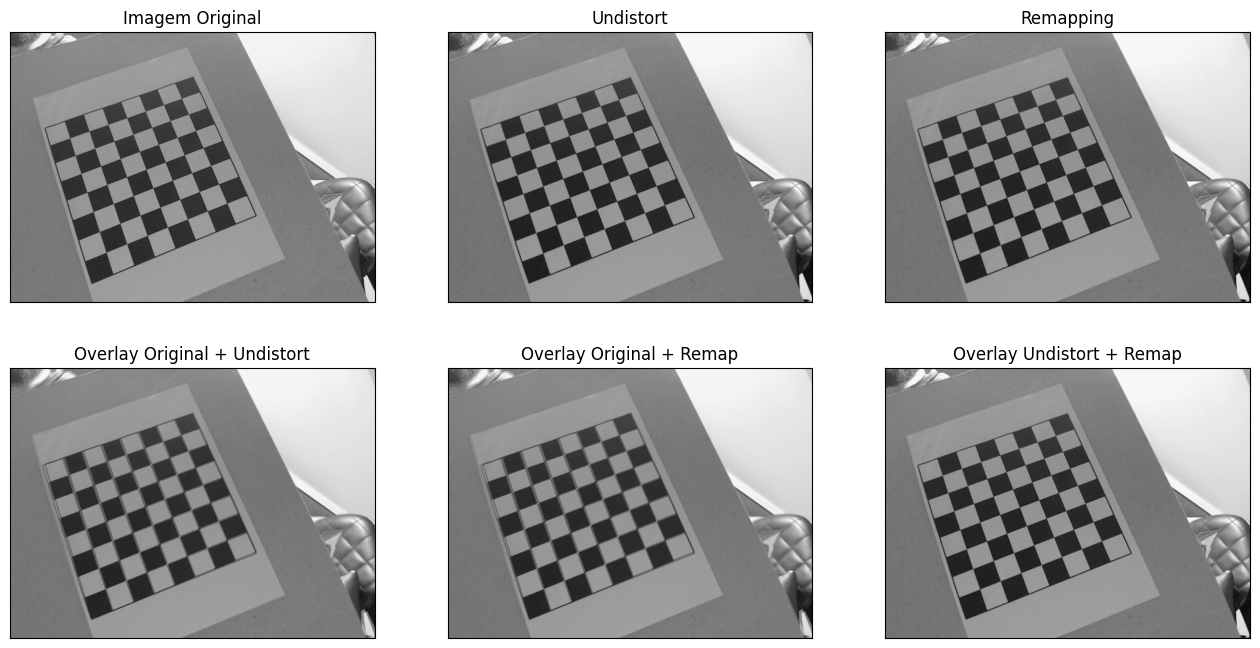

In [6]:
results('img/2023-05-31-213136.jpg')

Pode-se perceber que há apenas uma correção muito leve na imagem. Provavelmente, isso se deve ao fato de que a câmera é de boa qualidade e já tem mecanismos próprios para correção de distorções. A aplicação da calibração deve ter corrigido, portanto, apenas imperfeições referentes ao tabuleiro em si, uma vez que o mesmo é naturalmente flexível. Também é possível averiguar que, de fato, tanto o método `undistort` quanto o `remap` produzem a mesma imagem final.

Por fim, podemos usar novamente o código fornecido pela OpenCV para estimar o erro na obtenção dos parâmetros da câmera. Para este experimento, o erro foi superior a 7%, o que indica que de fato a significância desses resultados deve ser questionada. 

In [7]:
mean_error = 0

for i in range(len(objpoints)):
    imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2)/len(imgpoints2)
    mean_error += error
    
print( f"Erro total: {mean_error/len(objpoints)*100:.2f}%")

Erro total: 7.96%
